# Задание — написать алгоритмы для решения задачи о минимальном остовном дереве и сравнить их работу.

Целью каждой лабораторной работы является реализация, сравнение и анализ двух алгоритмов, решающих одну и ту же задачу. Задание считается выполненным после представления программы, тестов по задаче и беседы по работе. Программа по каждой лабораторной работе должна предусматривать пользовательский ввод данных для небольших значений параметров (тут желательна визуализация входных данных и ответа по задаче), а также предусматривать автоматическую генерацию растущих входных данных и построение графика производительности в зависимости от параметра.

Алгоритм Прима: сначала берётся произвольная вершина и находится ребро, инцидентное данной вершине и обладающее наименьшей стоимостью. Найденное ребро и соединяемые им две вершины образуют дерево. Затем, рассматриваются рёбра графа, один конец которых — уже принадлежащая дереву вершина, а другой — нет; из этих рёбер выбирается ребро наименьшей стоимости. Выбираемое на каждом шаге ребро присоединяется к дереву. Рост дерева происходит до тех пор, пока не будут исчерпаны все вершины исходного графа.

## Настройки/Гиперпараметры/Импорты

In [1]:
import numpy as np # для быстрой работы с массивами
import matplotlib.pyplot as plt # для вывода графиков
import networkx as nx # для построения графов
import random # для случайной генерации графов
import time # для подсчёта времени выполнения

In [2]:
random_state = 42 # для генератора случайных чисел
runs = 3 # число запусков для усреднения времени

## Вспомогательные функции

In [3]:
def print_graph(adj_matrix: np.array, edges=None, random_state: int=random_state) -> None:
    """
    функция для построения графа.\n
    Parameters:
        * adj_matrix: матрица смежности
        * edges: рёбра, что надо выделить
        * random_state: случайное число для отображения графа (положение вершин в пространстве)\n
    Returns:
        * None (выводит график)
    """
    plt.figure(figsize=(10,10)) # задание размера графика
    
    G = nx.from_numpy_array(adj_matrix) # создаём объект графа из списка смежности
    pos = nx.spring_layout(G, seed=random_state) # задание позиций вершин графа для графика (seed задаёт расположение вершин на графике)

    if edges is not None:
        for edge in edges: # идём по переданным рёбрам
            G[edge[0]][edge[1]]["color"] = '#1f78b4' # ребро будет синим
            G[edge[0]][edge[1]]["width"] = 3 # ширина ребра

    colors = [] # массив для цветов рёбер
    widths = [] # массив для ширины рёбер
    for edge in G.edges(): # идм по рёбрам
        if "color" in G[edge[0]][edge[1]]: # проверяем, есть ли у них цвет
            colors.append(G[edge[0]][edge[1]]["color"]) # если есть — добавляем его в массив цветов рёбер
        else: # иначе - цвет ребра будет чёрный
            colors.append("black")

        if "width" in G[edge[0]][edge[1]]: # проверяем, есть ли у них ширина
            widths.append(G[edge[0]][edge[1]]["width"]) # если есть — добавляем её в массив ширины рёбер
        else: # иначе - ширина ребра будет единичной
            widths.append(1)
        
    nx.draw_networkx(G, pos, width=widths, edge_color=colors) # построение графа, pos - позиции вершин графа, width - ширина ребра, edge_color - цвет рёбер
    labels = nx.get_edge_attributes(G, name='weight') # взятие атрибутов рёбер (веса) и запись его в переменную labels (будет идти названием ребёр)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels) # добавление подписей на рёбра

    plt.show() # вывод графа

In [4]:
def read_adj_matrix(path: str) -> np.array: # функция для ручного ввода (с помощью файла)
    """
    Функция для ручного ввода данных (с помощью файла).\n
    Parameters:
        * path: путь до файла с таблицей смежности\n
    Returns:
        * np.array: таблица смежности
    """
    adj_matrix = []
    with open(path, "r") as f: # открываем файл для чтения
        for line in f: # идём по строкам в файле
            adj_matrix.append([int(x) for x in line.split()]) # добавляем данные в матрицу смежности
    return np.array(adj_matrix) # возвращаем сконвертированную в np.array матрицу смежности 

In [5]:
def generate_graph(nodes_count: int=10) -> np.array:
    """
    Функция для генерации растущих входных данных.\n
    Parameters:
        * nodes_count: число вершин в создаваемом графе\n
    Returns:
        * np.array: таблица смежности
    """
    G = nx.complete_graph(nodes_count) # генерируем полносвязный граф без петель (диагональ в матрице смежности — нули, остальные элементы — единицы)
    adj_matrix = nx.to_numpy_array(G) # получаем матрицу смежности

    for i in range(nodes_count-1): # идём по элементам матрицы смежности (кроме последней строки, так как рассматриваем верхнетреугольную матрицу)
        for j in range(i+1, nodes_count): # идём по элементам матрицы смежности (рассматриваем верхнетреугольную матрицу)
            adj_matrix[i][j] = random.randint(0,100) # задаём случайный вес рёбрам от 0 до 100
            adj_matrix[j][i] = adj_matrix[i][j] # делаем матрицу симметричной

    return adj_matrix

In [6]:
def get_neighbors(adj_matrix: np.array) -> list:
    """
    Функция для получения соседей вершин в графе.\n
    Parameters:
        * adj_matrix: матрица смежности\n
    Returns:
        * list: список соседей для вершин
    """
    neighbors = [] # список окрестностей вершин
    for row in adj_matrix: # идём по строкам (row - список, в котором указаны веса рёбер до соседей)
        neighbors.append([]) # заготавливаем место для соседей рассматриваемой вершины
        for node, weight in enumerate(row): # рассматриваем в строке все вершины с их весом
            if weight > 0: # если вес больше нуля — есть ребро
                neighbors[-1].append(node) # добавляем вершину в окрестность
    return neighbors # возвращает список соседей для вершин

In [7]:
def performance_measurement(func, init_size: int=10, max_size: int=1000, step: int=10, runs: int=3) -> None:
    """
    Функция для построения графика производительности.\n
    Parameters:
        * func: функция для оценивания
        * init_size: начальный размер графа
        * max_size: максимальное число вершин в графе
        * step: на сколько вершин увеличивать графы
        * runs: число запусков с одинаковой генерацией для усреднения времени\n
    Returns:
        * None (строит графики производительности)
    """
    times = {"with labels": [], "with Fibonacci heap": []} # словарь для сохранения времени
    for nodes_count in range(init_size, max_size+1, step): # рассматриваем графы с числом вершин от init_size до max_size с шагом в step (max_size+1 чтобы захватить max_size в цикле)
        adj_matrix = generate_graph(nodes_count=nodes_count) # генерируем граф (матрицу смежности)

        neighbors = get_neighbors(adj_matrix) # получаем список соседей

        time_start = time.perf_counter() # замеряем текущее время
        for i in range(runs): # делаем несколько запусков для усреднения времени
            func(adj_matrix, neighbors) # запускаем алгоритм
        times["with labels"].append((time.perf_counter() - time_start)/runs) # сохраняем полученное время
        
#        time_start = time.perf_counter() # замеряем текущее время
#        for i in range(runs): # делаем несколько запусков для усреднения времени
#            alg_Prim_with_Fibonacci_heap(adj_matrix, neighbors) # запускаем алгоритм
#        time["with Fibonacci heap"].append((time.perf_counter() - time_start)/runs) # сохраняем полученное время
    

    plt.figure(figsize=(10,10)) # задание размера графика
    plt.title('Время работы алгоритмов в зависимости от размера графа') # название графика
    plt.plot(times["with labels"], "b", label='алгоритм Прима с метками') # построение графика времени выполнения алгоритма на метках
#    plt.plot(times["with Fibonacci heap"], "r", label='алгоритм Прима с Фибоначчиевой кучей') # построение графика времени выполнения алгоритма на Фибоначчиевой куче
    plt.xlabel('число вершин в графе') # подпись по оси x
    plt.ylabel('время работы алгоритма') # подпись по оси y
    plt.legend() # вывод названий графиков
    plt.show() # вывод графика
        

## 1) Алгоритм Прима на метках

В синий цвет окрашивается произвольная вершина графа. Далее на каждой итерации для текущего синего дерева вычисляется минимальное допустимое ребро (только один конец которого окрашен в синий). Это ребро и его неокрашенный конец красятся в синий цвет. 

In [11]:
def alg_Prim_with_labels(adj_matrix: np.array, neighbors: list) -> list: # на вход — список смежности связного графа (веса рёбер между вершинами, 0 - ребра нет) и список соседей вершин
    """
    Алгоритм Прима с метками.\n
    Parameters:
        * adj_matrix: матрица смежности
        * neighbors: соседи вершин графа\n
    Returns:
        * list: список рёбер минимального остовного дерева
    """
# подготовка — O(n)
    nodes_count = adj_matrix.shape[0] # число вершин в графе

    labels = np.zeros(shape=nodes_count) # создаём массив меток (размера числа вершин), пока все вершины считаются неокрашенными (метка - ноль)

    dists = np.full(shape=nodes_count, fill_value=np.inf) # список с минимальными путями (размера числа вершин), где на i-ой позиции длина ребра от вершины i до синего дерева (изначально заполнен inf)

    nodes_in_tree = np.full(shape=nodes_count, fill_value=nodes_count) # массив вторых концов рёбер, находящихся в синем дереве, где на i-ой позиции находится номер ближайшей вершины в синем дереве для i, нужен для быстрого добавления рёбер в solution (изначально заполнен недопустимым значением — на 1 больше числа вершин)

    solution = [] # массив для решения (список рёбер)

# начальная инициализация — O(n) из-за графа, в котором начальная вершина связана со всеми
    labels[0] = 1 # ставим первой вершине (идёт под индексом 0) метку окрашивания, то есть она теперь одновершинное окрашенное дерево
    for node in neighbors[0]: # идём по вершинам-соседям стартовой вершины
        dists[node] = adj_matrix[0, node] # обновляем их дистанцию до синего дерева
        nodes_in_tree[node] = 0 # обновляем вторые концы рёбер (стартовая вершина для них ближайшая в окрашенном дереве)
    
# добавление рёбер (вершин) в окрашенное синее дерево — O(n^2) из-за n-1 раза поиска вершины с наименьшим расстоянием за O(n) и обновлений для соседей за, в худшем случае, O(n) 
    while (len(solution)) < nodes_count-1: # итерируемся, пока рёбер не будет на 1 меньше, чем вершин в графе (по определению остовного дерева)
        possible_nodes = np.where(labels == 0)[0] # список возможных вершин для добавления (не окрашенных)
        node_to_add = possible_nodes[dists[possible_nodes].argmin()] # ищем ближайшую вершину к синему дереву, что будем добавлять 
        # dists[possible_nodes].argmin() - вернёт позицию вершины с минимальным расстоянием до синего дерева, однако такая позиция может быть смещена, так как мы оставили только те вершины, у которых нет метки окрашивания (possible_nodes)
        # поэтому берём настоящую вершину из possible_nodes по найденному в dists[possible_nodes].argmin() индексу

        labels[node_to_add] = 1 # ставим метку окрашивания выбранной вершине
        solution.append((nodes_in_tree[node_to_add], node_to_add)) # добавляем ребро в решение, где nodes_in_tree[node_to_add] - конец ребра, что уже в синем дереве
        for node in neighbors[node_to_add]: # идём по вершинам-соседям добавляемой в дерево вершины node_to_add
            if labels[node] == 0: # если соседняя вершина ещё не окрашена
                if dists[node] > adj_matrix[node_to_add, node]: # если расстояние от соседней вершины до дерева уменьшится при добавлении node_to_add в дерево
                    dists[node] = adj_matrix[node_to_add, node] # обновляем расстояние до синего дерева
                    nodes_in_tree[node] = node_to_add # изменяем второй конец ребра в окрашенном дереве

    return solution # возвращаем полученное оптимальное решение (список окрашенных синих рёбер)

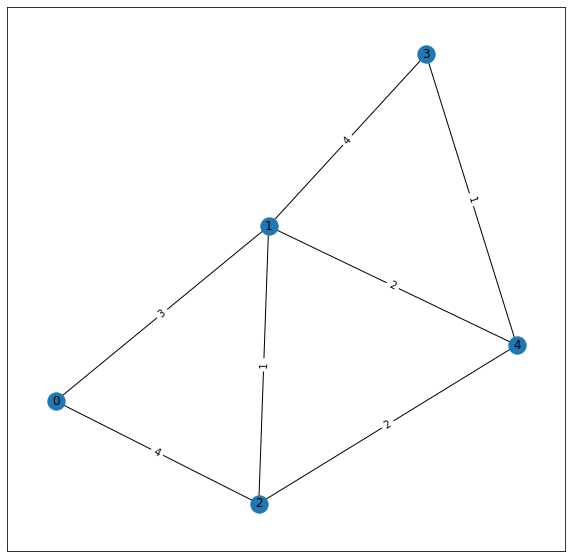

In [12]:
# adj_matrix = np.array([[0, 3, 4, 0, 0], [3, 0, 1, 4, 2], [4, 1, 0, 0, 2], [0, 4, 0, 0, 1], [0, 2, 2, 1, 0]]) # список смежности — веса ребёр (0 - ребра нет)
adj_matrix = read_adj_matrix("data/input1.txt") # считывание матрицы смежности

print_graph(adj_matrix) # вывод начального графа

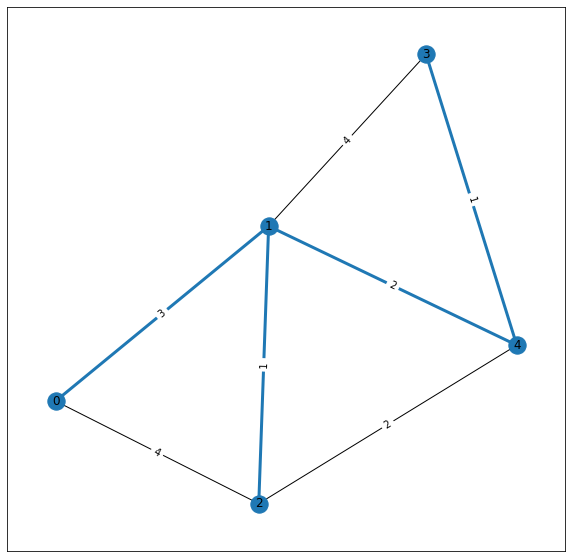

In [13]:
edges_prim_with_labels = alg_Prim_with_labels(adj_matrix=adj_matrix, neighbors=get_neighbors(adj_matrix)) # подсчёт остовного дерева алгоритмом Прима с метками
print_graph(adj_matrix=adj_matrix, edges=edges_prim_with_labels) # вывод остовного дерева

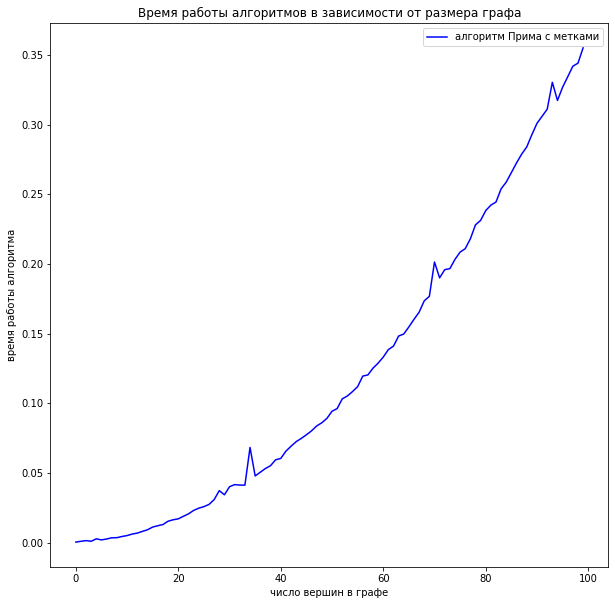

In [14]:
performance_measurement(func=alg_Prim_with_labels, runs=runs)

## 2) Алгоритм Прима на Фибоначчиевой куче

Идея: хранить расстояния до синего дерева только для неокрашенных вершин в формате приоритетной очереди (с использованием фибоначчиевой кучи).

In [181]:
import math

# простая реализация Фибоначчиевых куч и деревьев для алгоритма Прима 
# без учёта числа удалённых у вершины детей, удаления произвольной вершины, каскадного вырезания, уменьшения веса у произвольной вершины, объединения куч, так как они в задаче не используются

class Node:
    """
    Фибоначчиево дерево — биномиальное дерево, в котором у любого узла удаляется не более одного потомка.
    """
    def __init__(self, weight, node_in_graph=None): # создание дерева
        self.weight = weight # вес узла (длина ребра до синего дерева)
        self.node_in_graph = node_in_graph # модификация для задачи Прима, чтобы знать номер вершины с минимальным ребром

        self.parent = None # родитель
        self.left_bro = None # левый брат
        self.right_bro = None # правый брат
        self.child = None # список детей
        self.degree = 0 # число детей у узла
        self.remove_flag = False # метка, удалялся ли у вершины ребёнок

    def get_node_information(self): # функция для вывода информации о узле
        print(f"weight: {self.weight}")
        print(f"node_in_graph: {self.node_in_graph}")
        print(f"parent: {self.parent.weight if self.parent else self.parent}")
        print(f"left_bro: {self.left_bro.weight if self.left_bro else self.left_bro}")
        print(f"right_bro: {self.right_bro.weight if self.right_bro else self.right_bro}")
        print(f"child: {self.child.weight if self.child else self.child}")
        print(f"degree: {self.degree}")
        print(f"remove_flag: {self.remove_flag}")
        return 1

class FibonacciHeap:
    """
    Фибоначчиева куча — набор из подвешенных деревьев удовлетворяющих свойству: каждый предок не больше своих детей(если дерево на
    минимум). Это означает, что минимум всей кучи это один из корней этих деревьев. Одним из главных преимуществ Фибоначчиевой кучи
    — гибкость её структуры из-за того, что на деревья не наложены никакие ограничения по форме. Например, Фибоначчиева куча может
    состоять хоть из деревьев в каждом из которых по одному элементу. Такая гибкость позволяет выполнять некоторые операции лениво,
    оставляя работу более поздним операциям.
    """

    def __init__(self): # создание пустой кучи — O(1)
        self.min_node = None # дерево с минимальным корнем
        self.root_list_size = 0 # размер корневого списка (число узлов в корневом списке)

    def get_heap_information(self): # функция для вывода информации о дереве
        current_node = self.min_node # текущая вершина
        for i in range(self.root_list_size): # идём по корневому списку
            print("*****************")
            current_node.get_node_information() # выводим информацию о вершине
            child = current_node.child # обращаемся к связному списку детей вершины
            for i in range(current_node.degree): # идём по детям вершины
                print(f"*** child of {current_node.weight}")
                child.get_node_information() # выводим информацию о вершине
                child = child.right_bro # переходим к следующему ребёнку

            current_node = current_node.right_bro # переходим на следующую вершину в корневом списке


    def get_min(self): # возвращение минимального элемента кучи — O(1)
        return self.min_node
    
    def insert(self, weight, node_in_graph: int): # добавление узла (одноэлементное дерево Фибоначчи) в кучу — O(1)
        new_node = Node(weight, node_in_graph) # создаём новый узел (одноэлементное дерево Фибоначчи) с передачей его веса (веса ребра от синего дерева до вершины) и соответствующей вершины в графе
        if self.root_list_size == 0: # если в куче нет элементов
            self.min_node = new_node # назначаем добавляемый элемент минимальным
            self.min_node.left_bro = new_node # делаем ссылки на себя же (левый брат)
            self.min_node.right_bro = new_node # делаем ссылки на себя же (правый брат)
        else: # если в куче уже были элементы
            # как бы встраиваем новый узел в двусвязный список правее минимального
            prev_right = self.min_node.right_bro # запоминаем узел предыдущего правого брата минимального элемента (минимальный элемент будет "опорным" для итерации по куче)
            self.min_node.right_bro = new_node # заменяем правого брата у минимальной вершины на новую добавленную
            new_node.left_bro = self.min_node # у добавленного узла левым братом записываем минимальный
            new_node.right_bro = prev_right # у добавленного узла правым братом записываем предыдущего правого брата минимальной вершины
            prev_right.left_bro = new_node # обновляем левого брата (новый узел) прошлой правой вершины (от минимальной)
            if new_node.weight < self.min_node.weight: # если вес у нового добавленного узла меньше, чем был до этого в куче
                self.min_node = new_node # сдвигаем указатель минимального элемента
        self.root_list_size += 1 # увеличиваем размер корневого списка

    def union_nodes(self, node1: Node, node2: Node): # объединение двух двусвязных списков (как бы крест-накрест соединили) — O(1)
        prev_node1_left = node1.left_bro # запоминаем левого брата первой вершины
        prev_node2_right = node2.right_bro # запоминаем правого брата второй вершины
        node2.right_bro = node1 # связываем переданные вершины
        node1.left_bro = node2 # связываем переданные вершины
        prev_node1_left.right_bro = prev_node2_right # связываем братьев переданных вершин
        prev_node2_right.left_bro = prev_node1_left # связываем братьев переданных вершин

    def add_child(self, node: Node, child: Node): # добавление child в дети node
        # "изолируем" узел (поддерево) child
        child.left_bro.right_bro, child.right_bro.left_bro = child.right_bro, child.left_bro # "отрываем" child из двусвязного списка (на него теперь в двусвязном спике никто не указывает)
        child.left_bro, child.right_bro = child, child # его левый и правый браться — он сам (у узла-ребёнка остаются только ссылки на себя)

        if node.child is None: # если детей до этого у вершины node не было
            node.child = child # назначаем вершину ребёнком
        else: # если дети были — объединяем
            self.union_nodes(node.child, child) # объединяем списки
        child.parent = node # задаём родителя узлу-ребёнку
    
    # не используется
    # def merge_heaps(self, second_heap): # объединение двух куч (вызывается от первой кучи с передачей второй как аргумента) — O(1)
    #     if second_heap.root_list_size == 0: # если вторая куча пустая, то просто выходим
    #         return
    #     if self.root_list_size == 0: # если первая куча пустая, а вторая нет — просто присваиваем первой куче те же значения, что во второй (дублируем)
    #         self.min_node = second_heap.min_node 
    #         self.root_list_size = second_heap.root_list_size
    #     else: # если обе кучи не пустые
    #         self.union_nodes(self.min_node, second_heap.min_node) # объединяем двусвязные корневые списки у куч
    #         self.root_list_size += second_heap.root_list_size # увеличиваем размер корневого списка
    #         if self.min_node.weight < second_heap.min_node.weight: # если у второй кучи был элемент с меньшим весом
    #             self.min_node = second_heap.min_node # делаем ссылку на него в первой куче

    def consolidate(self): # консолидация преобразует кучу таким образом, что в корневом списке остается не более degree(Heap)+1 вершин (объединение деревьев с одинаковой степенью ~ числом детей у корня, что-то типа Round-Robin процедуры для биномиальных деревьев) — O(logn)
        # до консолидации в корневом списке было не более degree(Heap)+t(H)-1 деревьев, где degree(Heap) - максимальное число поддеревьев после удаления минимального узла, t(H)-1 - размер корневого списка после удаления минимального узла и без включения его поддеревьев)
        # а станет не более degree(Heap)+1 деревьев(корней)

        print("****************************")
        
        A = [None] * (int(math.log(self.root_list_size, 2)) + 1) # создаём массив для записи

        print(f"*root_list_size {self.root_list_size}, degree {self.min_node.degree}, A shape {len(A)}")

        A[self.min_node.degree] = self.min_node # записываем минимальный (на данный момент он не настоящий минимальный) элемент в массив

        current_node = self.min_node.right_bro # идём по вершинам, начиная с правой от "минимальной", саму "минимальную" мы уже добавили в массив

        for i in range(self.root_list_size-1): # идём по числу узлов в корневом списке (-1, так как минимальную вершину уже добавили)
            next_node = current_node.right_bro # запоминаем следующую вершину, если эту придётся объединить

            while A[current_node.degree] is not None: # пока не нашли пустую ячейку
                print(f"root_list_size {self.root_list_size}, degree {current_node.degree}, A shape {len(A)}")
                # если в массиве на позиции degree уже есть дерево, то объединяем их и пытаемся записать на позицию degree+1
                node_in_A = A[current_node.degree] # берём уже записанный узел, чтобы потом его объединить с current_node
                if node_in_A.weight < current_node.weight: # определяем, какое дерево к какому присоединять (присоединяем к тому, у которого вес меньше)
                    node_in_A, current_node = current_node, node_in_A # "меняем местами" узлы на текущей итерации

                self.add_child(current_node, node_in_A) # добавляем к детям current_node поддерево из node_in_A

                A[current_node.degree] = None # очищаем ячейку, с деревом из которой было объединение (ещё не инкрементировали степень вершины)
                current_node.degree += 1 # увеличиваем степень узла, к которому было проведено присоединение (и пытаемся записать в следующую ячейку)
                self.root_list_size -= 1 # уменьшаем размер корневого списка, так как при объединении стало на 1 дерево меньше 

            A[current_node.degree] = current_node # положим в пустую ячейку текущий элемент

            if current_node.weight < self.min_node.weight: # обновляем минимальный узел, если нужно
                self.min_node = current_node

            current_node = next_node # переходим к следующему узлу


    # def extract_min(self): # удаление минимального элемента кучи — O(logn) из-за консолидации
    #     prev_min = self.min_node # запоминаем текущий минимальный узел

    #     if self.min_node.child: # если у минимального узла есть дети (параметр не None)
    #         self.union_nodes(self.min_node, self.min_node.child) # объединяем корневой список и детей минимальной вершины (размер корневого списка становится degree(min_node)+root_list_size)
    #         # что становится с указателем на родителя??? как-нибудь перетрётся при консолидации
    #         self.root_list_size += self.min_node.degree # обновляем размер корневого списка

    #     # "изолируем" узел (но не поддерево) min_node
    #     self.min_node.left_bro.right_bro, self.min_node.right_bro.left_bro = self.min_node.right_bro, self.min_node.left_bro # "отрываем" min_node из двусвязного списка (на него теперь в двусвязном спике никто не указывает)
    #     self.root_list_size -= 1 # уменьшаем размер корневого списка на 1 (удалённый минимальный элемент)

    #     if prev_min.right_bro == prev_min: # если в корневом списке оказался лишь один узел (одноэлементная Фибоначчиева куча)
    #         self.min_node = None # зануляем указатель на минимальный элемент
    #     else: # иначе — "объединяем" фибоначчиевы деревья
    #         self.min_node = prev_min.right_bro # пока что перекинем указатель min на правого брата, а далее consolidate() скорректирует min в процессе выполнения
    #         self.consolidate() # вызываем консолидацию
    #     return prev_min # возвращаем минимальный элемент

    def extract_min(self): # удаление минимального элемента кучи — O(logn) из-за консолидации
        data_to_return = (self.min_node.weight, self.min_node.node_in_graph) # данные для возвращения из extract_min

        if self.min_node.child: # если у минимального узла есть дети (параметр не None)
            self.union_nodes(self.min_node, self.min_node.child) # объединяем корневой список и детей минимальной вершины (размер корневого списка становится degree(min_node)+root_list_size)
            # что становится с указателем на родителя??? как-нибудь перетрётся при консолидации
            self.root_list_size += self.min_node.degree # обновляем размер корневого списка

        # "изолируем" узел (но не поддерево) min_node
        self.min_node.left_bro.right_bro, self.min_node.right_bro.left_bro = self.min_node.right_bro, self.min_node.left_bro # "отрываем" min_node из двусвязного списка (на него теперь в двусвязном спике никто не указывает, однако он пока указывает на своих старых соседей)
        self.root_list_size -= 1 # уменьшаем размер корневого списка на 1 (удалённый минимальный элемент)

        if self.min_node.right_bro == self.min_node: # если в корневом списке оказался лишь один узел (одноэлементная Фибоначчиева куча)
            self.min_node = None # зануляем указатель на минимальный элемент
        else: # иначе — "объединяем" фибоначчиевы деревья
            self.min_node = self.min_node.right_bro # пока что перекинем указатель min на правого брата, а далее consolidate() скорректирует min в процессе выполнения
            self.consolidate() # вызываем консолидацию
        return data_to_return # возвращаем вес и номер вершины от минимальный элемент
    

    def cut(self, node: Node): # вырезание вершины — O(1)
        # "изолируем" узел 
        node.left_bro.right_bro, node.right_bro.left_bro = node.right_bro, node.left_bro # "отрываем" node из двусвязного списка (на него теперь в двусвязном спике никто не указывает)
        node.parent.degree -= 1 # уменьшаем степень вершины родителя

        if node.parent.child == node: # если узел node - связь родителя с детьми
            if node.right == node: # если у родительской вершины был всего один ребёнок
                node.parent.child = None # теперь у вершины нет детей
            else: # иначе — смещаем ссылку на соседнего ребёнка
                node.parent.child = node.right_bro
        
        node.right_bro, node.left_bro = node, node # удаляем ссылки на братьев у node
        node.parent = None # удаляем ссылку на родителя у вершины
        self.union_nodes(self.min_node, node) # добавляем узел (с поддеревом) в корневой список


    def cascade_cut(self, node: Node): # рекурсивная функция вырезания родителей — O(1), амортизированная
        # Если у вершины до этого не удаляли дочерний узел (node.remove_flag=False), то мы помечаем эту вершину (node.remove_flag=True) и прекращаем выполнение операции. 
        # В противном случае применяем операцию cut для текущей вершины и запускаем каскадное вырезание от родителя.
        while node.remove_flag: # вырезаем, пока у родителей есть метка, что уже одно ребёнка у них вырезали
            parent = node.parent # запоминаем родителя для следующей итерации (так как в cut он превращается в None)
            self.cut(node) # вырезаем узел
            node = parent # переходим к следующему родителю
        node.remove_flag = True # помечаем последнюю вершину, что у неё удалялся узел-ребёнок


    def decrease_weight(self, node: Node, new_weight): # уменьшение веса элемента (ребра от синего дерева до вершины node.node_in_graph) — O(1), амортизированная
        # Было бы хорошо, чтобы вершина не всплывала до корня, и тогда дерево не придется сильно перестраивать. 
        # Для этого при удобном случае будем вырезать поддерево полностью и перемещать его в корневой список

        # изменение веса в сторону увеличения, видимо, не рассматривается
        if new_weight > node.parent.weight: # если новый вес не нарушил свойство кучи
            node.weight = new_weight # просто обновляем вес
        else: # иначе — вызываем вырезание вершины (и помещение её в корневой список) и каскадное вырезание её родителей, пока не найдём вершину, у которой вырезанние ребёнка случилось впервые (remove_flag = False)
            parent = node.parent # запоминаем родителя
            self.cut(node) # вырезаем вершину
            self.cascade_cut(parent) # каскадно вырезаем родителей
        if node.weight < self.min_node.weight: # обновляем указатель на минимальный элемент, если потребуется
            self.min_node = node

    def delete(self, node: Node): # удаление вершины — O(logn) из-за удаления минимального элемента
        # Удаление вершины реализуется через уменьшение ее веса до -inf и последующим извлечением минимума.
        self.decrease_weight(node, np.inf) # уменьшаем вес вершины на inf
        self.extract_min() # удаляем минимальную вершину

In [ ]:
heap = FibonacciHeap()
heap.insert(5,5)
heap.insert(1,1)
heap.insert(2,2)
heap.insert(3,3)
heap.insert(4,4)
# heap.get_min().get_node_information()
# heap.get_min().right_bro.get_node_information()
# heap.get_min().right_bro.right_bro.get_node_information()
# heap.get_min().right_bro.right_bro.right_bro.get_node_information()
# heap.get_min().right_bro.right_bro.right_bro.right_bro.get_node_information()
print("*****")
heap.extract_min().get_node_information()
print("*****")
heap.extract_min().get_node_information()
print("*****")
heap.extract_min().get_node_information()
print("*****")
# heap.consolidate()
heap.get_heap_information()
# heap.get_min().right_bro.right_bro.get_node_information()
# heap.get_min().left_bro.get_node_information()
# heap.get_min().right_bro.get_node_information()

In [172]:
def alg_Prim_with_Fibonacci_heap(adj_matrix: np.array, neighbors: list) -> list: # на вход — список смежности связного графа (веса рёбер между вершинами, 0 - ребра нет) и список соседей вершин
    """
    Алгоритм Прима с Фибоначчиевой кучей.\n
    Parameters:
        * adj_matrix - матрица смежности
        * neighbors - соседи вершин графа\n
    Returns:
        * list (список рёбер минимального остовного дерева)
    """

    # подготовка — O(n)
    nodes_count = adj_matrix.shape[0] # число вершин в графе
    
    labels = np.zeros(shape=nodes_count) # создаём массив меток (размера числа вершин), пока все вершины считаются неокрашенными (метка - ноль)

    dists = np.full(shape=nodes_count, fill_value=np.inf) # список с минимальными путями (размера числа вершин), где на i-ой позиции длина ребра от вершины i до синего дерева (изначально заполнен inf)
    
    heap = FibonacciHeap() # куча с путями до синего дерева
    
    nodes_in_tree = np.full(shape=nodes_count, fill_value=nodes_count) # массив вторых концов рёбер, находящихся в синем дереве, где на i-ой позиции находится номер ближайшей вершины в синем дереве для i, нужен для быстрого добавления рёбер в solution (изначально заполнен недопустимым значением — на 1 больше числа вершин)
    solution = [] # массив для решения (список рёбер)

    # начальная инициализация — O(n) из-за графа, в котором начальная вершина связана со всеми
    heap.insert(0, 0) # добавляем в кучу вершину 0 с дистанией до неё 0
    for node in neighbors[0]: # идём по вершинам-соседям стартовой вершины
        heap.insert(adj_matrix[0, node], node) # обновляем кучу (добавляем в неё узел с длиной ребра и номером вершины)
        dists[node] = adj_matrix[0, node] # обновляем дистанцию от вершин до синего дерева
        nodes_in_tree[node] = 0 # обновляем вторые концы рёбер (стартовая вершина для них ближайшая в окрашенном дереве)
    heap.extract_min() # удаляем нулевую (стартовую) вершину из дерева
    labels[0] = 1 # запоминаем, что окрасили стартовую вершину

    # добавление рёбер (вершин) в окрашенное синее дерево 
    while (len(solution)) < nodes_count-1: # итерируемся, пока рёбер не будет на 1 меньше, чем вершин в графе (по определению остовного дерева)
        # print("***************************")
        # heap.get_heap_information()
        # print(solution)
        # print("***************************")
        node_to_add = heap.extract_min()[1] # берём вершину с минимальным весом

        labels[node_to_add] = 1 # ставим метку окрашивания выбранной вершине
        solution.append((nodes_in_tree[node_to_add], node_to_add)) # добавляем ребро в решение, где nodes_in_tree[node_to_add] - конец ребра, что уже в синем дереве
        for node in neighbors[node_to_add]: # идём по вершинам-соседям добавляемой в дерево вершины node_to_add
            if labels[node] == 0: # если вершина ещё не окрашена
                if dists[node] > adj_matrix[node_to_add, node]: # если расстояние от соседней вершины до дерева уменьшится при добавлении node_to_add в дерево
                    dists[node] = adj_matrix[node_to_add, node] # обновляем расстояние до синего дерева
                    nodes_in_tree[node] = node_to_add # изменяем второй конец ребра в окрашенном дереве
                    heap.insert(adj_matrix[node_to_add, node], node) # добавляем новые веса 

    return solution # возвращаем полученное оптимальное решение (список окрашенных синих рёбер)

***************************
*****************
weight: 3
node_in_graph: 1
parent: None
left_bro: 3
right_bro: 3
child: 4
degree: 1
remove_flag: False
*** child of 3
weight: 4
node_in_graph: 2
parent: 3
left_bro: 4
right_bro: 4
child: None
degree: 0
remove_flag: False
[]
***************************
***************************
*****************
weight: 1
node_in_graph: 2
parent: None
left_bro: 4
right_bro: 2
child: None
degree: 0
remove_flag: False
*****************
weight: 2
node_in_graph: 4
parent: None
left_bro: 1
right_bro: 4
child: None
degree: 0
remove_flag: False
*****************
weight: 4
node_in_graph: 3
parent: None
left_bro: 2
right_bro: 4
child: None
degree: 0
remove_flag: False
*****************
weight: 4
node_in_graph: 2
parent: 3
left_bro: 4
right_bro: 1
child: None
degree: 0
remove_flag: False
[(0, 1)]
***************************
***************************
*****************
weight: 2
node_in_graph: 4
parent: None
left_bro: 4
right_bro: 4
child: 4
degree: 1
remove_flag: F

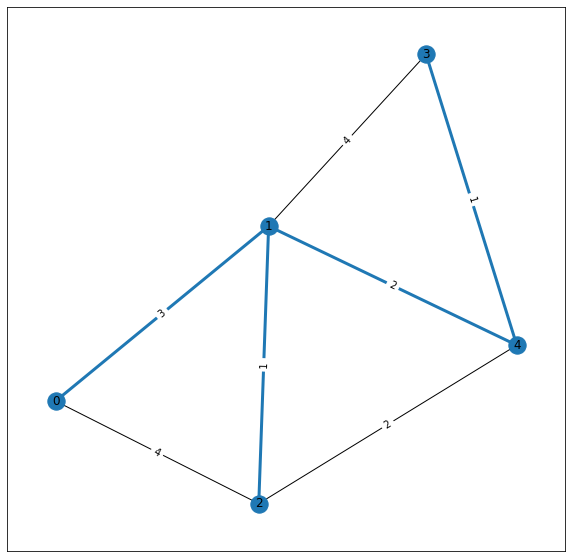

In [170]:
edges_prim_with_fib_heap = alg_Prim_with_Fibonacci_heap(adj_matrix=adj_matrix, neighbors=get_neighbors(adj_matrix)) # подсчёт остовного дерева алгоритмом Прима с метками
print_graph(adj_matrix=adj_matrix, edges=edges_prim_with_fib_heap) # вывод остовного дерева

In [182]:
performance_measurement(func=alg_Prim_with_Fibonacci_heap, runs=runs)

****************************
*root_list_size 9, degree 0, A shape 4
root_list_size 9, degree 0, A shape 4
root_list_size 8, degree 0, A shape 4
root_list_size 7, degree 1, A shape 4
root_list_size 6, degree 0, A shape 4
root_list_size 5, degree 0, A shape 4
root_list_size 4, degree 1, A shape 4
root_list_size 3, degree 2, A shape 4
****************************
*root_list_size 4, degree 0, A shape 3
root_list_size 4, degree 0, A shape 3
root_list_size 3, degree 1, A shape 3
root_list_size 2, degree 2, A shape 3


IndexError: list index out of range